# Recurrent Neural Network Assignment
## Gabriel Marcelino, Grant Burk, Eli   
## CST-435
**October 30, 2024**  


## Problem Statement
Goal is to develop a neural network model capable of predicting the next word in a sentence based on a given sequence of words. This model should use a recurrent neural network (RNN), specifically an LSTM architecture, to understand the sequential context of text data. By training on a large corpus of text, the model will be able to suggest the most likely word to follow a given input sequence.

## 1. Import Requirements and Load data


In [36]:
import kagglehub
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
import random
from nltk.tokenize import sent_tokenize
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

path = kagglehub.dataset_download("mikeortman/wikipedia-sentences")
nltk.download('punkt_tab')

print("Path to dataset files:", path)

# List files in the dataset directory
files = os.listdir(path)
print("Files in dataset:", files)

# Select a subset of files (e.g., first 10 files)
subset_files = files[:10]
print("Subset of files:", subset_files)

# Load and process the subset of files
data = ""
for file in subset_files:
    with open(os.path.join(path, file), 'r', encoding='utf-8') as f:
        data += f.read()

print("Loaded data from subset of files")

# Taking too long to run -> Use only the first 100,000 characters for testing
data = data[:8000000]

Path to dataset files: /Users/gabriel/.cache/kagglehub/datasets/mikeortman/wikipedia-sentences/versions/3
Files in dataset: ['wikisent2.txt']
Subset of files: ['wikisent2.txt']


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/gabriel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Loaded data from subset of files


## 2. Visualize data

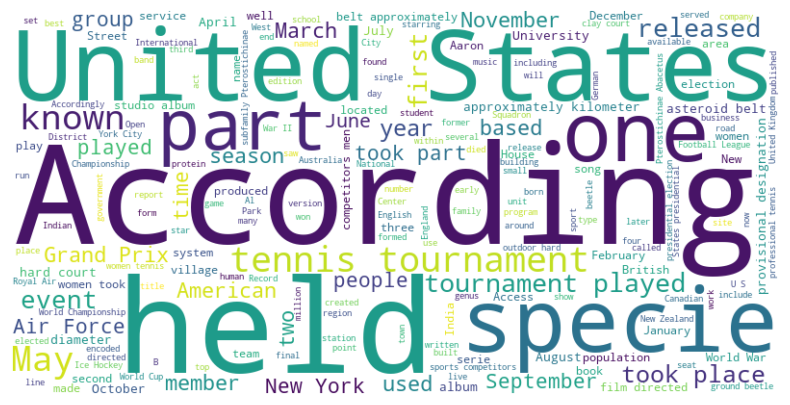

In [37]:
# Visualize data with a word cloud to see most common words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## 3. Prepare Data

In [38]:
# Sample of data before
print(data[:1000])

# Step 1: Split the text into sentences
sentences = sent_tokenize(data)

# Step 2: Remove punctuation from each sentence using a compiled regular expression
punctuation_re = re.compile(r'[^\w\s]')
sentences = [punctuation_re.sub('', sentence) for sentence in sentences]

# Sample of data after removing punctuation and splitting into sentences
print(sentences[:10])

# Step 3: Convert each sentence into a sequence of integers using Keras tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)  # Fit on the entire dataset at once
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)  # Convert each sentence into a sequence of integers
# preview the first 10 sequences
print(sequences[:10])

0.000123, which corresponds to a distance of 705 Mly, or 216 Mpc.
000webhost is a free web hosting service, operated by Hostinger.
0010x0010 is a Dutch-born audiovisual artist, currently living in Los Angeles.
0-0-1-3 is an alcohol abuse prevention program developed in 2004 at Francis E. Warren Air Force Base based on research by the National Institute on Alcohol Abuse and Alcoholism regarding binge drinking in college students.
0.01 is the debut studio album of H3llb3nt, released on February 20, 1996 by Fifth Colvmn Records.
001 of 3 February 1997, which was signed between the Government of the Republic of Rwanda, and FAPADER.
003230 is a South Korean food manufacturer.
0.04%Gas molecules in soil are in continuous thermal motion according to the kinetic theory of gasses, there is also collision between molecules - a random walk.
0.04% of the votes were invalid.
005.1999.06 is the fifth studio album by the South Korean singer and actress Uhm Jung-hwa.
005 is a 1981 arcade game by Sega.

## 4. Create Features and Labels

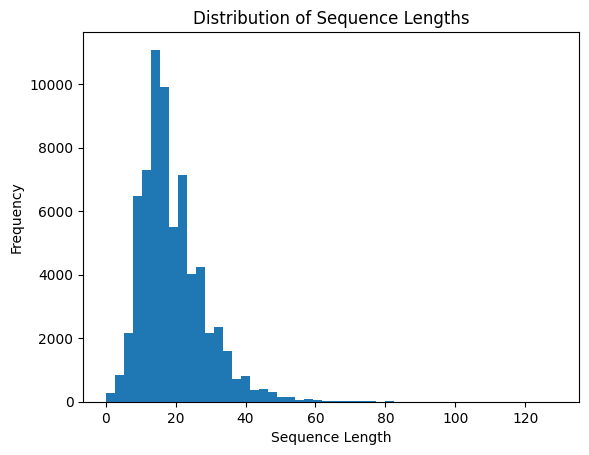

Adjusted max sequence length: 75
Shape of X after padding: (5054200, 74)
Shape of X_small: (40000, 74)
Shape of y_small before one-hot encoding: (40000,)
Final shapes:
X_train: (32000, 74)
X_test: (8000, 74)
y_train: (32000, 5000)
y_test: (8000, 5000)


In [39]:
# Step 1: Check if `sequences` is not empty before padding
if len(sequences) > 0:
    sequence_lengths = [len(seq) for seq in sequences]
    plt.hist(sequence_lengths, bins=50)
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of Sequence Lengths')
    plt.show()

    # Set a reasonable max sequence length based on the distribution
    max_sequence_len = min(max(sequence_lengths), 75)  # Use 75 as a reasonable length
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='post')
    print(f"Adjusted max sequence length: {max_sequence_len}")

    # Create input-output pairs
    X = []
    y = []

    for sentence in padded_sequences:
        for i in range(1, len(sentence)):
            X.append(sentence[:i])
            y.append(sentence[i])

    # Pad input sequences
    X = pad_sequences(X, maxlen=max_sequence_len - 1, padding='post')
    print(f"Shape of X after padding: {X.shape}")
else:
    print("Warning: 'sequences' is empty. Check your input data.")

# Step 2: Ensure `X` and `y` are not empty before proceeding
if len(X) > 0 and len(y) > 0:
    # Step 3: Reduce dataset size and create smaller arrays
    X = np.array(X)
    y = np.array(y)

    # Ensure dataset is large enough for slicing
    if X.shape[0] >= 40000:
        X_small = X[:40000].astype(np.int32)  # Convert to 32-bit integers
        y_small = y[:40000]
        y_small = np.where(y_small >= max_vocab_size, 0, y_small)  # Replace rare words with OOV token
        print(f"Shape of X_small: {X_small.shape}")
        print(f"Shape of y_small before one-hot encoding: {y_small.shape}")
    else:
        print("Warning: Dataset is smaller than 40,000 samples; skipping truncation.")

    # Step 4: Split the data into chunks if they are not empty
    chunk_size = 5000
    num_chunks = len(X_small) // chunk_size

    X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = start_idx + chunk_size
        X_chunk = X_small[start_idx:end_idx]
        y_chunk = y_small[start_idx:end_idx]

        # Split each chunk if it contains data
        if len(X_chunk) > 0 and len(y_chunk) > 0:
            X_train_chunk, X_test_chunk, y_train_chunk, y_test_chunk = train_test_split(
                X_chunk, y_chunk, test_size=0.2, random_state=42 + i
            )
            X_train_list.append(X_train_chunk)
            X_test_list.append(X_test_chunk)
            y_train_list.append(y_train_chunk)
            y_test_list.append(y_test_chunk)

    # Combine the chunks if they exist
    if X_train_list and X_test_list and y_train_list and y_test_list:
        X_train = np.concatenate(X_train_list)
        X_test = np.concatenate(X_test_list)
        y_train = np.concatenate(y_train_list)
        y_test = np.concatenate(y_test_list)

        # Convert to one-hot encoding only after splitting
        y_train = to_categorical(y_train, num_classes=vocab_size)
        y_test = to_categorical(y_test, num_classes=vocab_size)

        print("Final shapes:")
        print(f"X_train: {X_train.shape}")
        print(f"X_test: {X_test.shape}")
        print(f"y_train: {y_train.shape}")
        print(f"y_test: {y_test.shape}")

    else:
        print("Error: One or more lists are empty after chunking and splitting.")

    # Memory cleanup
    del X_train_list, X_test_list, y_train_list, y_test_list, X_small, y_small
else:
    print("Error: 'X' or 'y' is empty after padding and alignment. Check your input data.")


## 5. Build Model

In [40]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Load GloVe embeddings
embedding_index = {}
glove_path = 'glove.42B.300d.txt'
if not os.path.exists(glove_path):
    print(
        f"File {glove_path} not found. Please download it from https://nlp.stanford.edu/projects/glove/ and place it in the current directory.")
else:
    with open(glove_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs

    print(f"Loaded {len(embedding_index)} word vectors.")

# Create an embedding matrix
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build the model with Bidirectional LSTM
model = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_len - 1,
              trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),  # Increased dropout rate
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(vocab_size, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping and ModelCheckpoint callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
]

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

def sample_with_temperature(preds, temperature=1.0):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds + 1e-10) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def predict_next_word(text, num_words=5, temperature=1.4):
    sequence = tokenizer.texts_to_sequences([text])[0]
    generated_text = []

    for _ in range(num_words):
        padded = pad_sequences([sequence], maxlen=max_sequence_len - 1, padding='pre')

        pred = model.predict(padded, verbose=0)[0]
        next_word_idx = sample_with_temperature(pred, temperature)

        if next_word_idx == 0:
            break

        sequence.append(next_word_idx)
        generated_text.append(tokenizer.index_word.get(next_word_idx, ""))

    return " ".join(generated_text)

# Testing the function
test_sentences = ["The quick brown", "Artificial intelligence is", "In the year", "Learning to code"]
for test_sentence in test_sentences:
    completed_text = predict_next_word(test_sentence, num_words=10)
    print(f"Original: {test_sentence}")
    print(f"Completed: {test_sentence} {completed_text}")

# Enhanced Evaluation Function
def evaluate_model():
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"\nTest Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

# Run enhanced evaluation
evaluate_model()


Loaded 1917494 word vectors.
Epoch 1/20


2024-11-03 17:03:59.346689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


400/400 ━━━━━━━━━━━━━━━━━━━━ 89s 213ms/step - accuracy: 0.7894 - loss: 2.7020 - val_accuracy: 0.8044 - val_loss: 1.8038
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 88s 221ms/step - accuracy: 0.8131 - loss: 1.6563 - val_accuracy: 0.8044 - val_loss: 1.8451
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 85s 213ms/step - accuracy: 0.8141 - loss: 1.4673 - val_accuracy: 0.8044 - val_loss: 1.9480
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 85s 212ms/step - accuracy: 0.8137 - loss: 1.3617 - val_accuracy: 0.8044 - val_loss: 1.9368
Original: The quick brown
Completed: The quick brown 
Original: Artificial intelligence is
Completed: Artificial intelligence is 
Original: In the year
Completed: In the year 16 pulmonate air transportation
Original: Learning to code
Completed: Learning to code malayalam americans
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.8128 - loss: 1.7052

Test Loss: 1.7184
Test Accuracy: 0.8105
